In [ ]:
import time

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
from joblib import Memory
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from torch import nn

from concrete.ml.sklearn import NeuralNetClassifier

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


### Load the data

We download the train and test data-sets from OpenML.

In [ ]:
# scikit-learn's fetch_openml method doesn't handle local cache:
# https://github.com/scikit-learn/scikit-learn/issues/18783#issuecomment-723471498
# This is a workaround that prevents downloading the data every time the notebook is ran
memory = Memory("./data/MNIST")
fetch_openml_cached = memory.cache(fetch_openml)

# Fetch the MNIST data-set, with inputs already flattened
mnist_dataset = fetch_openml_cached("mnist_784")

________________________________________________________________________________
[Memory] Calling sklearn.datasets._openml.fetch_openml...
fetch_openml('mnist_784')
____________________________________________________fetch_openml - 75.1s, 1.3min


We now need to normalize the values and split the inputs and targets into a test and train data-set.

In [ ]:
# Define max, mean and std values for the MNIST data-set
max_value = 255
mean = 0.1307
std = 0.3081

# Normalize the training data
data = (mnist_dataset.data) / max_value
data = ((data - mean) / std).round(decimals=4)

# Concrete ML's NNs do not support: category, str, object types
# FIXME: https://github.com/zama-ai/concrete-ml-internal/issues/2990
target = mnist_dataset.target.astype("int")

In [ ]:
test_size = 10000
x_train, x_test, y_train, y_test = train_test_split(
    data, target, test_size=test_size, random_state=0
)

Let's plot the first images from the train data.

In [ ]:
def plot_samples(data, targets, n_samples=5, title="Train target"):
    # MNIST images are originally of shape 28x28 with grayscale values
    samples_to_plot = np.array(data)[:n_samples].reshape((n_samples, 28, 28))

    fig = plt.figure(figsize=(30, 30))

    for i in range(n_samples):
        subplot = fig.add_subplot(1, n_samples, i + 1)
        subplot.set_title(f"{title}: {np.array(targets)[i]}", fontsize=15)
        subplot.imshow(samples_to_plot[i], cmap="gray", interpolation="nearest")

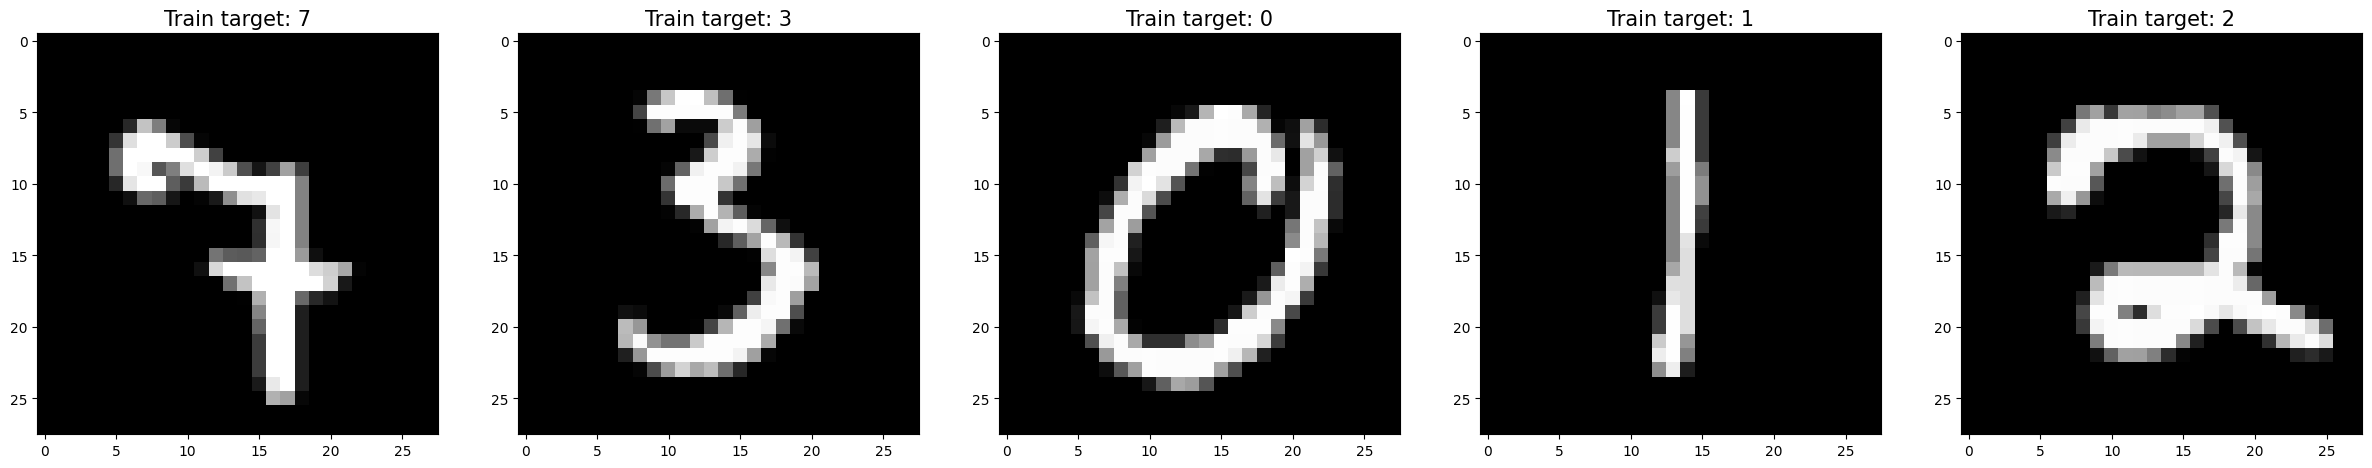

In [ ]:
plot_samples(x_train, y_train)

### Instantiate the model

This step is easy to achieve as we use a built-in Fully Connected Neural Network. Only a few input parameters are needed:
- `module__n_layers`: number of Fully Connected layers to use in the model
- `module__n_w_bits` and `module__n_a_bits`: respectively the number of bits to use for quantizing the weight and input/activation values as the FHE can currently only compute integers. These numbers should not become too large as it can cause the compilation step to fail (see Compile section below)
- `module__n_accum_bits`: The maximal allowed bit-width to target for intermediate accumulators. It is currently set to 15 as the actual maximum bit width reached during compilation can be up to one bit higher than this targeted value, in this case 16, which is the maximal value that Concrete ML currently supports.
- `module__n_hidden_neurons_multiplier`: A factor that is multiplied by the maximal number of active (non-zero weight) neurons for every layer. Default to 4 but set to 1 here in order to speed up all executions without changing the test accuracy by much. More detail in the qqn documentation.
- `module__activation_function`: The activation function to use
- `max_epochs`: The number of epochs to consider

In [ ]:
params = {
    "module__n_layers": 1,
    "module__n_w_bits":2,
    "module__n_a_bits": 2,
    "module__n_accum_bits": 8,
    "module__n_hidden_neurons_multiplier": 0.5,
    "module__activation_function": nn.ReLU,
    "max_epochs": 5,
}

model = NeuralNetClassifier(**params)

### Train the model

The fit method handles Pandas DataFrame as inputs.

In [ ]:
model.fit(X=x_train, y=y_train);

  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        1.5824       0.5215        1.4738  12.2179
      2        1.5091       0.4893        1.4955  5.2192
      3        1.4901       0.4609        1.5683  3.7064
      4        1.4837       0.4861        1.5327  4.7585
      5        1.4959       0.5315        1.3957  3.6281


### Compute predictions in the clear

We then compute the accuracy score reached by the model when executed in the clear. It is important to understand that no FHE computations are done here. This step is not necessary but helps illustrate what results should we expect from the model. It is therefore used to demonstrate that FHE computations are exact, meaning the FHE accuracy score will exactly match this very one.

In [ ]:
y_preds_clear = model.predict(x_test, fhe="disable")

print(f"The test accuracy of the clear model is {accuracy_score(y_test, y_preds_clear):.2f}")

The test accuracy of the clear model is 0.54


### Compile the model

A Concrete ML model needs to be compiled on an input-set, usually the train set or one of its sub-set, before being able to predict. This step creates an FHE circuit, which essentially saves elements found in the model's inference (graph of operations, shapes, bit-width precisions, etc.) needed for the compiler when executing the predictions in FHE during the `predict` method.

The maximum bit-width that can be reached by any values (inputs, weights, accumulators) in this circuit is currently 16-bits. If this limit is exceeded, the compilation fails and the user needs to change some of the model's parameters (e.g., decrease the number of quantization bits or decrease `module__n_accum_bits`).

<!---
Make it compile in non-VL when 2037 is done
FIXME: https://github.com/zama-ai/concrete-ml-internal/issues/2307
-->

In [ ]:
# Reduce the input-set's length to make the compilation time faster
# The input-set should be large enough to be representative of the input data
inputset = x_train.head(500)
simulated_fhe_circuit = model.compile(inputset)

# Print the circuit's maximum bit-width reached during compilation
print(f"Circuit of {simulated_fhe_circuit.graph.maximum_integer_bit_width()}-bits (FHE simulation)")

Circuit of 6-bits (FHE simulation)


### Compute the accuracy score with FHE simulation

Now, we compute the accuracy score reached by the FHE model with FHE simulation. The accuracy score obtained by simulation, which is faster, is expected to be the same as the one obtained in FHE.

In [ ]:
# Evaluate the model using simulation
y_preds_simulated = model.predict(x_test.head(1000), fhe="simulate")

print(
    "The test accuracy (with FHE simulation) of the FHE model is "
    f"{accuracy_score(y_test.head(1000), y_preds_simulated):.2f}"
)

The test accuracy (with FHE simulation) of the FHE model is 0.52


### Measure FHE inference time


Now, let's compute some predictions in FHE. In order to make the computations faster, we will consider a sample of the original test set and compare these results to the expected values.

We execute the key generation separately from the predictions in order to be able to measure its execution time.

In [ ]:
# Print the circuit's maximum bit-width reached during compilation
print(f"FHE circuit of {model.fhe_circuit.graph.maximum_integer_bit_width()}-bits")

time_begin = time.time()
model.fhe_circuit.client.keygen(force=True)
print(f"Key generation time: {time.time() - time_begin:.2f} seconds")

FHE circuit of 6-bits
Key generation time: 0.00 seconds


In [ ]:
# Reduce the test set
n_samples = 2
x_test_sample = x_test.head(n_samples)
y_test_sample = y_test.head(n_samples)

# Execute the predictions using FHE simulation on a few samples
simulated_fhe_predictions = model.predict(x_test_sample, fhe="simulate")

time_begin = time.time()
fhe_predictions = model.predict(x_test_sample, fhe="execute")
seconds_per_sample = (time.time() - time_begin) / len(x_test_sample)
print(f"Execution time in FHE: {seconds_per_sample:.2f} seconds per sample\n")

print("Expected values:", y_test_sample.tolist())
print("Simulated prediction values:", simulated_fhe_predictions)
print("FHE prediction values:", fhe_predictions)

Execution time in FHE: 0.09 seconds per sample

Expected values: [0, 4]
Simulated prediction values: [0 4]
FHE prediction values: [0 4]


### Prune the model to optimize its inference speed

Removing redundant neurons through pruning is a technique that helps improve inference speed. This
  through PBS which is computationally expensive.

The following code shows how to test multiple pruning amounts, and chooses a pruning amount that
preserves the initial accuracy while removing many neurons.

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.4378       0.5197        1.4587  3.7931
      2        1.4367       0.5100        1.4526  5.5555
      3        1.4350       0.5057        1.5091  4.3137
      4        1.4317       0.5331        1.4069  3.6755
      5        1.4337       0.5362        1.4163  3.9596
Pruning  0.00% of neurons.. test accuracy (with FHE simulation) of the FHE model is 0.53
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.4378       0.5197        1.4587  4.9540
      2        1.4367       0.5100        1.4526  3.5678
      3        1.4350       0.5057        1.5091  3.6822
      4        1.4317       0.5331        1.4069  4.3483
      5        1.4337       0.5362        1.4163  4.2371
Pruning 20.00% of neurons.. test accuracy (with FHE simulation) of the FHE model is 0.53
  epoch    train_loss   

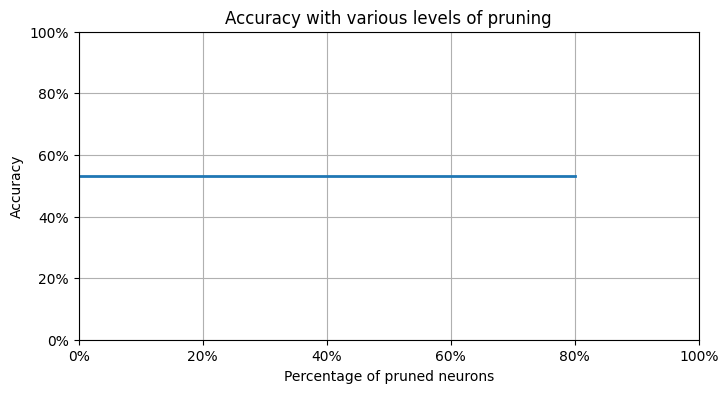

In [ ]:
pruned_models = {}
pruned_acc = []
all_prune_pct = np.arange(0.0, 1.0, 0.2)

for idx, prune_pct in enumerate(all_prune_pct):
    pruned_model = model.prune(x_train, y_train, prune_pct)
    pruned_model.compile(inputset)
    y_preds_simulated = pruned_model.predict(x_test, fhe="simulate")
    acc_pruned = accuracy_score(y_test, y_preds_simulated)
    print(
        f"Pruning {prune_pct*100:5.2f}% of neurons.. test accuracy (with FHE simulation) "
        f"of the FHE model is {acc_pruned:.2f}"
    )
    pruned_acc.append(acc_pruned * 100)
    pruned_models[idx] = pruned_model

fig, ax = plt.subplots(figsize=(8, 4))
xticks = mtick.FormatStrFormatter(fmt="%.0f%%")
ax.xaxis.set_major_formatter(xticks)
ax.yaxis.set_major_formatter(xticks)
plt.plot((all_prune_pct * 100).tolist(), pruned_acc, linewidth=2)
plt.title("Accuracy with various levels of pruning")
plt.xlabel("Percentage of pruned neurons")
plt.ylabel("Accuracy")
plt.xlim((0, 100))
plt.ylim((0, 100))
plt.grid(True)
plt.show()

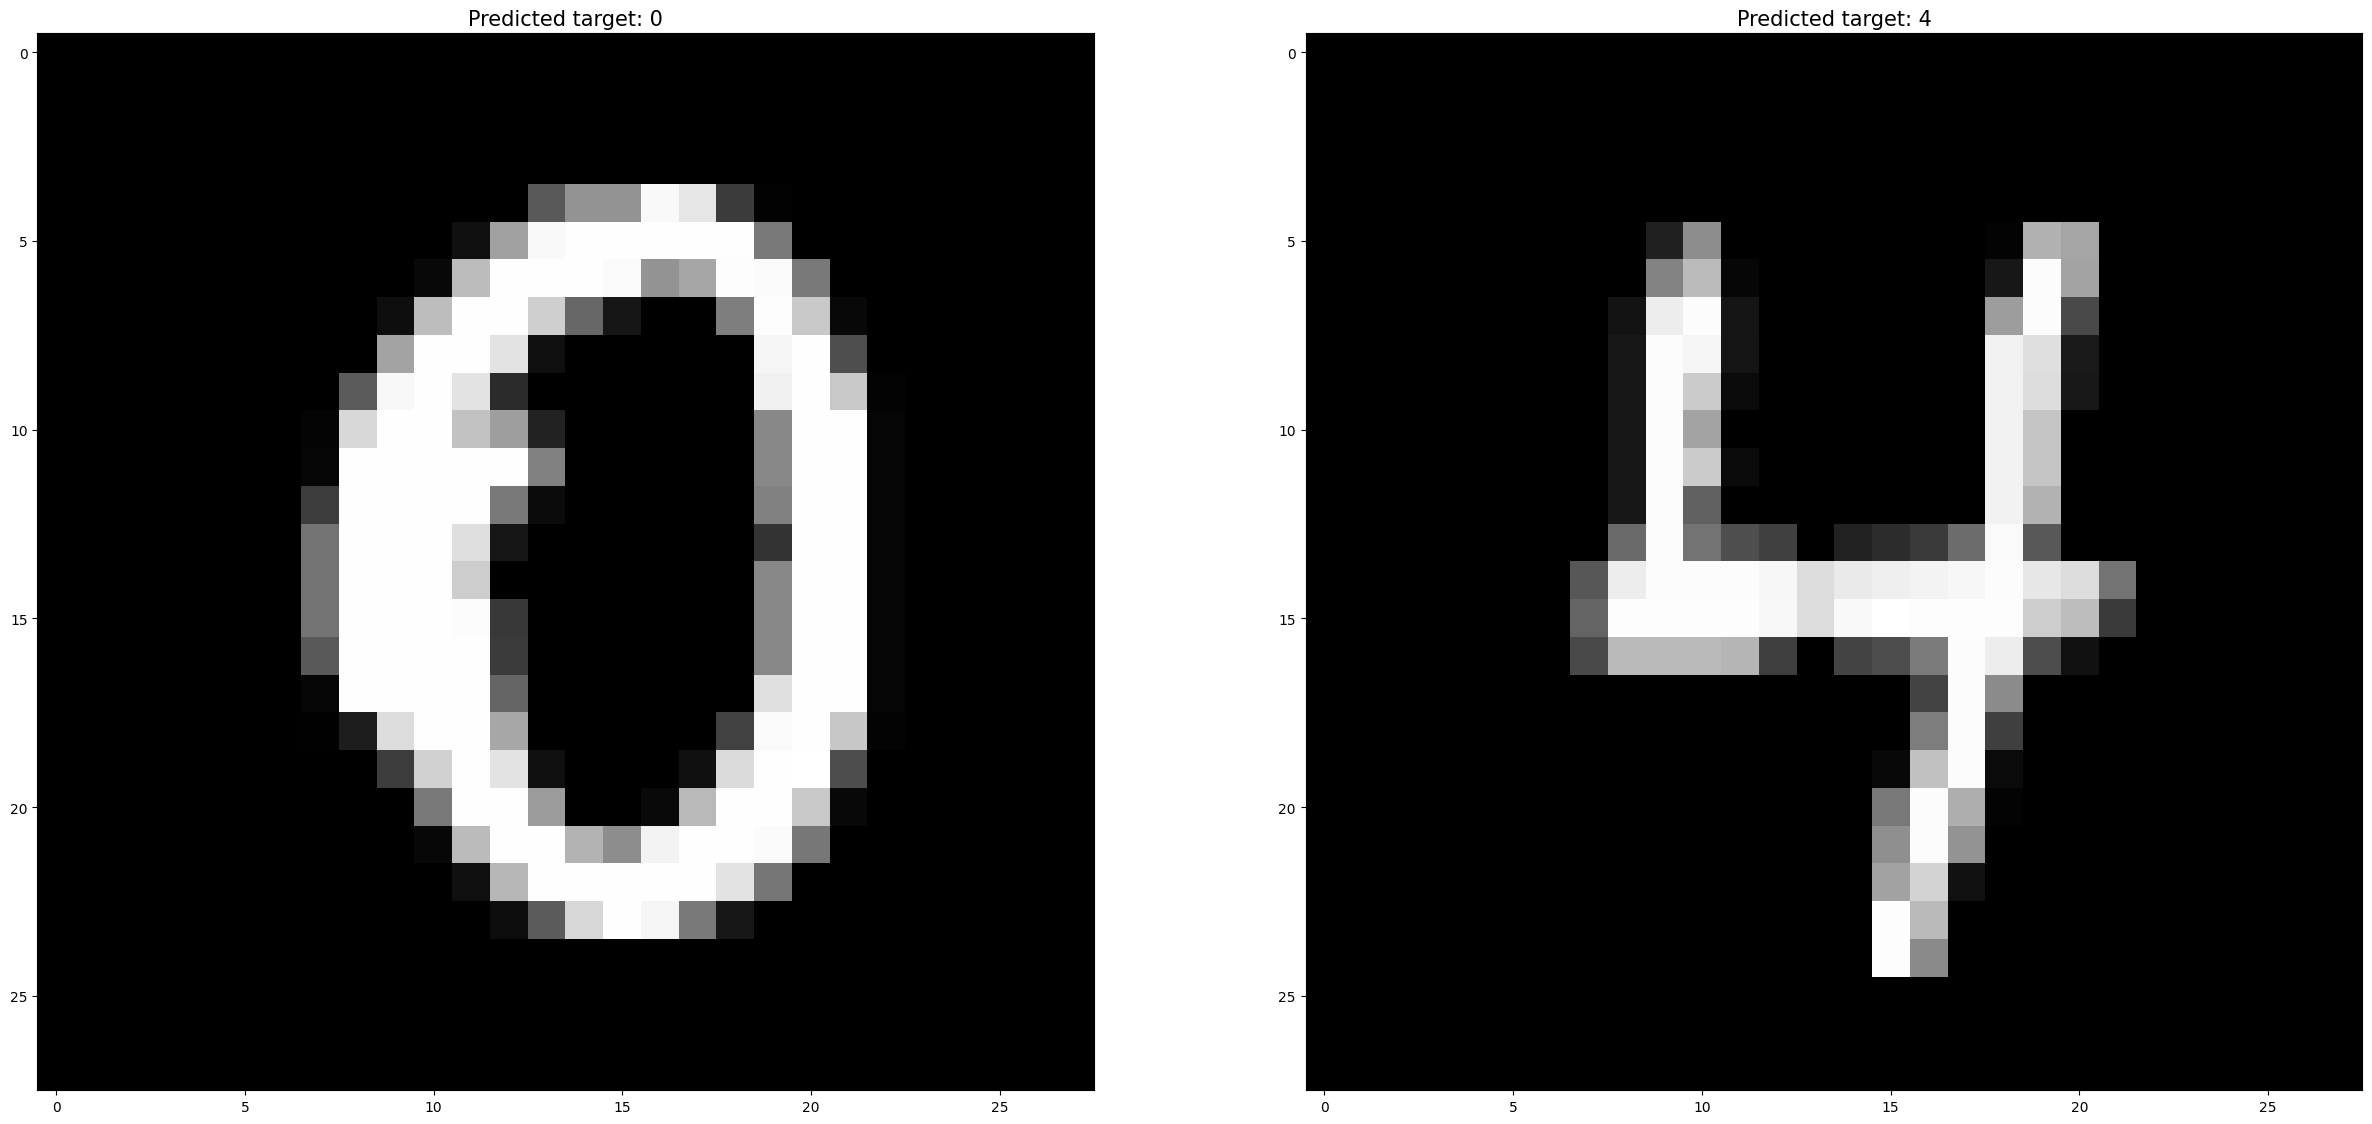

In [ ]:
plot_samples(x_test, fhe_predictions, n_samples=n_samples, title="Predicted target")

In [ ]:
# Choose the model that prunes 50% of neurons
pruned_model = pruned_models[2]

fhe_circuit = pruned_model.compile(inputset)

time_begin = time.time()
fhe_circuit.client.keygen(force=True)
print(f"Key generation time: {time.time() - time_begin:.2f} seconds")

# Print the circuit's maximum bit-width reached during compilation
print(f"FHE circuit of {fhe_circuit.graph.maximum_integer_bit_width()}-bits")

# Execute the predictions using FHE on a few samples
start_time = time.time()
fhe_predictions = pruned_model.predict(x_test_sample, fhe="execute")
seconds_per_sample = (time.time() - time_begin) / len(x_test_sample)
print(f"Execution time in FHE: {seconds_per_sample:.2f} seconds per sample\n")

print("Expected values: ", y_test_sample.tolist())
print("FHE prediction values:", fhe_predictions)

Key generation time: 0.00 seconds
FHE circuit of 6-bits
Execution time in FHE: 0.08 seconds per sample

Expected values:  [0, 4]
FHE prediction values: [0 4]


## Conclusion

In this notebook, we showed how to use a built-in Fully Connected Neural Network classifier on the MNIST data-set using the Concrete ML library in order to make its inference completely secure.

Training, compiling and evaluation such a model is intuitive as our API follows most common Machine Learning APIs. In fact, only a few additional parameters related to quantization are requested, such as `module__n_w_bits`, `module__n_a_bits` or `module__n_accum_bits`. Thanks to the internal implementation of Quantize Aware Training (QAT) techniques, the Concrete ML `NeuralNetCLassifier` model reached a high accuracy score.

A single FHE execution using the initial model takes several minutes on a multi-core machine.

After pruning, keeping accuracy constant, the execution time is reduced to by a factor of 2-3. Structured pruning is a useful tool to improve the speed of neural networks while keeping accuracy constant.